# Project UAV

Version 3.0


#### 1. call packages

In [1]:
import time

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.patches as mpatches

from scipy.spatial import distance_matrix

from sklearn.cluster import KMeans

from IPython.display import display, clear_output

import frigidum
from frigidum.examples import tsp

#### 2. initial parameters


In [2]:
NUM_GU = 10  # number of ground users

X_MIN = 0  # minimum x-axis [meter]
X_MAX = 100  # maximum x-axis [meter]
Y_MIN = 0  # minimum y-axis [meter]
Y_MAX = 100  # maximum y-axis [mseter]

UAV_ALTITUDE = 10  # altitude of uav [meter]
MAX_BEAM_ANGLE = 60  # maximum beamforming angle [degree]
UAV_SPEED = 6  # uav speed [m/s]

# calculate maximum beamforming diameter [meter]
MAX_BEAM_DIAMETER = 2 * UAV_ALTITUDE * np.tan(MAX_BEAM_ANGLE * np.pi / 180)

# calculate maximum distance between uav and gu [meter]
MAX_BEAM_DISTANCE = UAV_ALTITUDE / np.cos(MAX_BEAM_ANGLE * np.pi / 180)

X_GRID = 10  # number of x grid
Y_GRID = 10  # number of y grid

TX_POWER = 32  # transmit power [dBm]
F = 1e9  # frequency 1GH [Hz]
C = 299792458  # speed of light [m/s]

UAV_TX_POWER = 30  # uav's transmit power in [dBm]


#### 3. calculate receive power based on distance `d`

In [3]:
def calc_rx_power(d):
    # received power [mWh]
    return 1 * 10 ** ((TX_POWER - (20 * np.log10((4 * np.pi * d * F) / C))) / 10) * 1000

#### 4. generate location of gu

In [4]:
# generate ground user location randomly x,y,z [meters]
gu_x = np.random.uniform(low=X_MIN, high=X_MAX, size=(NUM_GU,))
gu_y = np.random.uniform(low=Y_MIN, high=Y_MAX, size=(NUM_GU,))
gu_z = np.zeros((NUM_GU,))

gu_x = np.array([
    9.04330840e+01, 9.96817955e+01, 7.63398634e+01, 8.98037139e+01, 7.22245261e+01,
    8.36605843e+01, 10.27225613e-0, 4.05986793e+01, 5.80821532e+01, 9.93099118e+01
])

gu_y = np.array([
    13.73014649e+0, 78.77941627, 60.47122501, 71.19842815, 70.31373701,
    77.84923832, 60.52589075, 10.41285009, 85.11544206, 46.38436827
])

gu_z = np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

gu_xyz = np.array((gu_x, gu_y, gu_z)).T

gu_xyz


array([[90.433084  , 13.73014649,  0.        ],
       [99.6817955 , 78.77941627,  0.        ],
       [76.3398634 , 60.47122501,  0.        ],
       [89.8037139 , 71.19842815,  0.        ],
       [72.2245261 , 70.31373701,  0.        ],
       [83.6605843 , 77.84923832,  0.        ],
       [10.27225613, 60.52589075,  0.        ],
       [40.5986793 , 10.41285009,  0.        ],
       [58.0821532 , 85.11544206,  0.        ],
       [99.3099118 , 46.38436827,  0.        ]])

#### 5. use `k-mean` algorithm

to find the center head of the gu, i use `k-mean` algirhtm

In [5]:
# i use k-mean algorithm 
# to find the center with 7 cluster-head
kmeans = KMeans(
    n_clusters=7,
    n_init="auto"
).fit(gu_xyz)

centers = kmeans.cluster_centers_
clear_output(False)

centers


array([[99.3099118 , 46.38436827,  0.        ],
       [58.0821532 , 85.11544206,  0.        ],
       [40.5986793 , 10.41285009,  0.        ],
       [10.27225613, 60.52589075,  0.        ],
       [91.0486979 , 75.94236091,  0.        ],
       [90.433084  , 13.73014649,  0.        ],
       [74.28219475, 65.39248101,  0.        ]])

In [6]:
aa = KMeans(
    n_clusters=7,
    n_init="auto"
).fit(gu_xyz)


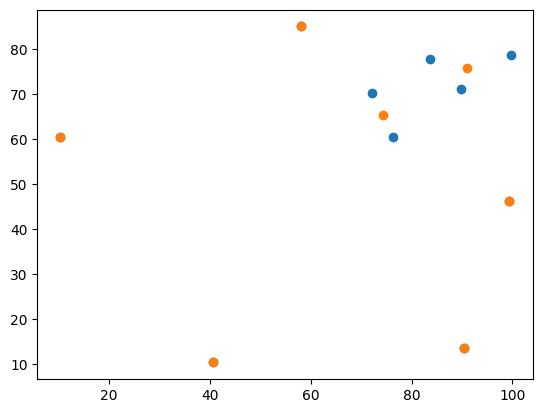

In [7]:
plt.scatter(gu_xyz[:, 0], gu_xyz[:, 1])


plt.scatter(centers[:, 0], centers[:, 1])


plt.grid(False)


#### 6. user `frigidum` algorithm

to find the route i use `frigidum` algorithm

In [8]:
# insert the center of the map as initial point 
points = np.vstack(([[50, 50]], centers[:, 0:2]))

# i use frigidum package to find the optimal route
# can be used DAESOL's algorithm
tsp.nodes = points
tsp.nodes_count = len(points)
tsp.dist_eu = distance_matrix(points, points)

local_opt = frigidum.sa(
    random_start=tsp.random_start,
    objective_function=tsp.objective_function,
    neighbours=[
        tsp.euclidian_bomb_and_fix,
        tsp.euclidian_nuke_and_fix,
        tsp.route_bomb_and_fix,
        tsp.route_nuke_and_fix,
    ],
    copy_state=frigidum.annealing.naked,
    T_start=5,
    alpha=.8,
    T_stop=0.01,
    repeats=10 ** 2,
    post_annealing=tsp.local_search_2opt
)

T: 0.010, M: 0.00, O_min: 295.3569, O_current: 295.3569: 100%|██████████| 28/28 [00:02<00:00, 10.55cooling/s]

---
Neighbour Statistics: 
(proportion of proposals which got accepted *and* changed the objective function)
   euclidian_bomb_and_fix           : 0.026239
   euclidian_nuke_and_fix           : 0.045255
   route_bomb_and_fix               : 0.025496
   route_nuke_and_fix               : 0.024896
---
(Local) Minimum Objective Value Found: 
   295.35688638


In [9]:
# get the route variable 
tmp_route = local_opt[0]

# make the loop by adding the starting point 
# as the end point
route = np.append(
    np.roll(tmp_route, -np.squeeze(np.argwhere(tmp_route == 0))), 0)

route

array([0, 3, 6, 1, 5, 7, 2, 4, 0])

#### 7.  make uav flying only

Note: there is no hovering duration here

In [10]:
# calculate flying direction vectors
direction = {}
norm_direction = {}
for i in range(len(route) - 1):
    direction[i] = points[route[i + 1], :] - points[route[i], :]
    norm_direction[i] = direction[i] / np.linalg.norm(direction[i])


In [11]:
# initial variables
t = 0  # time [second]
index = 0  # index of the route

GU_BAT_MAX = 200

gu_bat = np.zeros((NUM_GU,))

HOVER_DURATION = 20
uav_hov_dur = np.append(HOVER_DURATION * np.ones(len(centers)), 0)

# initial uav location at time t = 0s
uav_time = {}
uav_time[t] = np.squeeze(points[[route[0], ], :])

while True:
    # for t in np.arange(0, 50):

    t += 1  # increase time t

    # update the next location of uav
    uav_time[t] = np.squeeze(uav_time[t - 1] + UAV_SPEED * norm_direction[index])

    # calculate the next location vs. the end point
    tmp = (uav_time[t] - points[route[index + 1], :]) / \
          np.linalg.norm(uav_time[t] - points[route[index + 1], :])

    # calculate distance
    distance_uav2gu = distance_matrix(
        [np.append(uav_time[t], UAV_ALTITUDE)], gu_xyz)

    # calculate receive power
    rx_power = calc_rx_power(distance_uav2gu)

    # update the gu battery base on the maximum distance
    gu_bat += (rx_power * (distance_uav2gu <= MAX_BEAM_DISTANCE))[0]

    # print((rx_power*(distance_uav2gu <= MAX_BEAM_DISTANCE))[0])

    # if next location is longer than end point
    # thus, change direction
    if np.all(np.abs(tmp - norm_direction[index]) < 1e-3):

        uav_time[t] = points[route[index + 1], :]

        if index < len(centers):

            if np.all(gu_bat[(distance_uav2gu <= MAX_BEAM_DISTANCE)[0]] > GU_BAT_MAX):
                # gu_bat[index] = GU_BAT_MAX

                index = index + 1
                pass
            else:
                pass

    if np.all(gu_bat > GU_BAT_MAX):
        break

    # loop until reach the last point
    if index == len(points):
        break



In [12]:
uav_time[0]

array([50., 50.])

#### 8. plot the figure

NameError: name 'beam_circle' is not defined

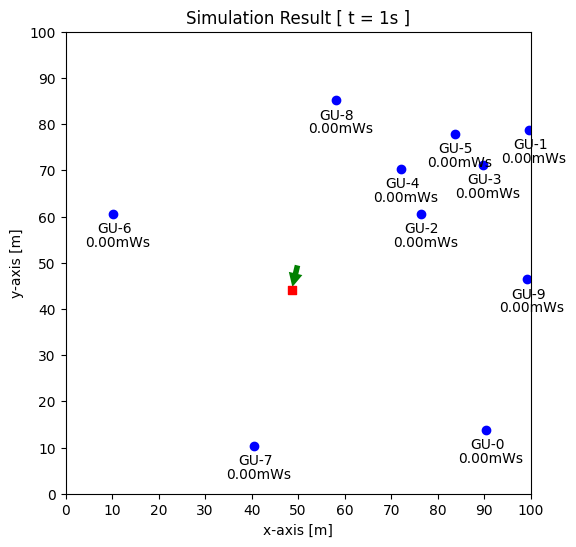

In [13]:
# position of uav at time n


# call the figure
fig, ax = plt.subplots()
fig.set_figwidth(6)
fig.set_figheight(6)

# design the axis
ax.set_xlabel("x-axis [m]")
ax.set_ylabel("y-axis [m]")
ax.set_xticks(np.arange(X_MIN, X_MAX + 1, X_GRID))
ax.set_yticks(np.arange(Y_MIN, Y_MAX + 1, Y_GRID))
ax.set_xlim(X_MIN, X_MAX)
ax.set_ylim(Y_MIN, Y_MAX)
ax.grid(False)

# initial the batter of gus
gu_bat = np.zeros((NUM_GU,))

# plot initial location of gus with batteries
current_batt = []
for i in range(NUM_GU):
    ax.scatter(x=gu_x[i], y=gu_y[i], c="blue")
    ax.text(x=gu_x[i] - 3.5, y=gu_y[i] - 4, s=f"GU-{i}")
    current_batt.append(
        ax.text(x=gu_x[i] - 6, y=gu_y[i] - 7, s=f"{gu_bat[i]:.2f}mWs"))

# initial variables
t = 0  # time [second]
index = 0  # index of the route

# initial uav location at time t = 0s
uav_time = {}
uav_time[t] = np.squeeze(points[[route[0], ], :])
uav_time[0] = np.array([50., 50.])

# plot real time update trajectory
for t in range(50):

    t = t + 1  # increase time t

    # update the next location of uav
    uav_time[t] = np.squeeze(uav_time[t - 1] + UAV_SPEED * norm_direction[index])

    # calculate the next location vs. the end point
    tmp = (uav_time[t] - points[route[index + 1], :]) / \
          np.linalg.norm(uav_time[t] - points[route[index + 1], :])

    # if next location is longer than end point
    # thus, change direction
    if np.all(np.abs(tmp - norm_direction[index]) < 1e-3):
        uav_time[t] = points[route[index + 1], :]
        index = index + 1

    # update title
    ax.set_title(f"Simulation Result [ t = {t}s ]")

    # calculate distance
    distance_uav2gu = distance_matrix(
        [np.append(uav_time[t], UAV_ALTITUDE)], gu_xyz)

    # calculate receive power
    rx_power = calc_rx_power(distance_uav2gu)

    # update the gu battery base on the maximum distance
    gu_bat += (rx_power * (distance_uav2gu <= MAX_BEAM_DISTANCE))[0]

    # plot arrow
    arrow = mpatches.FancyArrowPatch(
        (uav_time[t - 1][0], uav_time[t - 1][1]),
        (uav_time[t][0], uav_time[t][1]),
        edgecolor="none",
        facecolor="green",
        mutation_scale=20,
        zorder=0
    )
    tmp = ax.add_patch(arrow)

    # scatter uav location
    scatter_uav = ax.scatter(
        x=uav_time[t][0],
        y=uav_time[t][1],
        c="red",
        marker="s",
        zorder=1
    )

    # remove the previous beam cirle and plot the new one
    if t > 0:
        beam_circle.remove()

    # update beam circle  
    beam_circle = Ellipse(
        xy=(uav_time[t][0], uav_time[t][1]),
        width=MAX_BEAM_DIAMETER,
        height=MAX_BEAM_DIAMETER,
        angle=0,
        edgecolor="none",
        facecolor="orange",
        alpha=0.2,
        zorder=0,
    )
    uav_beam = ax.add_patch(beam_circle)

    # remove the previous battery text
    for i in range(NUM_GU):
        current_batt[i].remove()
        current_batt[i] = ax.text(
            x=gu_x[i] - 6, y=gu_y[i] - 7, s=f"{gu_bat[i]:.2f}mWs")

    # update the figure
    display(fig)
    clear_output(wait=True)

    # set the time sleep
    time.sleep(0.001)

In [ ]:
gu_bat

In [ ]:
# call the figure
fig, ax = plt.subplots()
# fig.set_figwidth(6)
# fig.set_figheight(6)

ax.bar(range(10), gu_bat)

ax.set_xlabel("Index of GUs")
ax.set_ylabel("GUs' battery [mWs]")

ax.set_xticks(range(10), [f"GU-{i}" for i in range(10)])

ax.grid(False)